# Задача

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Нам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Построим модель с предельно большим значением *F1*-меры. Проверим *F1*-меру на тестовой выборке.

Дополнительно измерим *AUC-ROC*, сравнивим её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

# Описание данных

Наименования столбцов:
* `RowNumber` - индекс строки в данных
* `CustomerId` - уникальный идентификатор клиента
* `Surname` - фамилия
* `CreditScore` - кредитный рейтинг
* `Geography` - страна проживания
* `Gender` - пол
* `Age` - возраст
* `Tenure` - сколько лет человек являлся клиентом банка
* `Balance` - баланс на счете
* `NumOfProducts` - количество продуктов банка, используемых клиентом
* `HasCrCard` - наличие кредитной карты
* `IsActiveMember` - активность клиента
* `EstimatedSalary` - предполагаемая зарплата
* `Exited` - факт ухода клиента

# Подготовка данных

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import precision_score, recall_score, auc, accuracy_score, roc_auc_score, f1_score,\
classification_report, roc_curve
from sklearn.utils import shuffle

import warnings
warnings.filterwarnings("ignore")

RAND = 22

In [2]:
df = pd.read_csv('Churn.csv', index_col='RowNumber')

In [3]:
df.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10000 non-null  int64  
 1   Surname          10000 non-null  object 
 2   CreditScore      10000 non-null  int64  
 3   Geography        10000 non-null  object 
 4   Gender           10000 non-null  object 
 5   Age              10000 non-null  int64  
 6   Tenure           9091 non-null   float64
 7   Balance          10000 non-null  float64
 8   NumOfProducts    10000 non-null  int64  
 9   HasCrCard        10000 non-null  int64  
 10  IsActiveMember   10000 non-null  int64  
 11  EstimatedSalary  10000 non-null  float64
 12  Exited           10000 non-null  int64  
dtypes: float64(3), int64(7), object(3)
memory usage: 1.1+ MB


Таблица состоит из 10 000 строк и 14 столбцов. Есть 909 пропусков в столбце `Tenure`.

In [5]:
# посмотрим информацию о столбцах
df.describe(include='all')

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,1.000000e+04,10000,10000.000000,10000,10000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
unique,NaN,2932,NaN,3,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,Smith,NaN,France,Male,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,32,NaN,5014,5457,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,1.569094e+07,NaN,650.528800,NaN,NaN,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,7.193619e+04,NaN,96.653299,NaN,NaN,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.556570e+07,NaN,350.000000,NaN,NaN,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,1.562853e+07,NaN,584.000000,NaN,NaN,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,1.569074e+07,NaN,652.000000,NaN,NaN,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,1.575323e+07,NaN,718.000000,NaN,NaN,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000


***Выводы***

- Средний возраст клиентов 39 лет   
- Половина клиентов из Франции  
- В среднем клиентами банка являются 5 лет  
- Средний баланс клиентов равен 76485. Медиана равна 62397. Среднее больше чем медиана, значит график скошен вправо
- Соотношение мужчин и женщин среди клиентов практически 50 на 50 (мужчин чуть больше)

In [6]:
# удалим неинформативные признаки
df = df.drop(['CustomerId','Surname'], axis=1)

In [7]:
# изменим названия столбцов на нижний регистр с разделителями
df.columns = df.columns.str.replace(r"([A-Z])", r" \1").str.lower().str.replace(' ', '_').str[1:]

In [8]:
df.columns

Index(['credit_score', 'geography', 'gender', 'age', 'tenure', 'balance',
       'num_of_products', 'has_cr_card', 'is_active_member',
       'estimated_salary', 'exited'],
      dtype='object')

### Заполнение пропусков в  столбце tenure

In [9]:
# посмотрим процент пропусков в столбце tenure
x1 = df['tenure'].isna().sum() / 10000
f'Количество пропусков в столбце tenure: {x1:.1%}'

'Количество пропусков в столбце tenure: 9.1%'

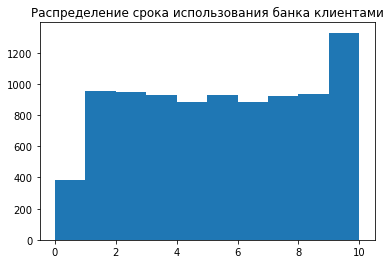

In [10]:
# Tenure — сколько лет человек является клиентом банка
plt.hist(df['tenure'])
plt.title('Распределение срока использования банка клиентами')
plt.show()

Распределение по годам использования банка практически ровное, если сейчас заменить 909 пропусков медианой, то мы увеличим в 2 раза значение для 5 лет. Это кажется некорректным. Можно сделать заполнение пропусков случайными числами, тогда мы снизим влияние на наше распределение.

In [11]:
np.random.seed(42)
tenure = np.random.randint(0, 10 , size=df['tenure'].isna().sum())
df.loc[df['tenure'].isna(), 'tenure'] = tenure

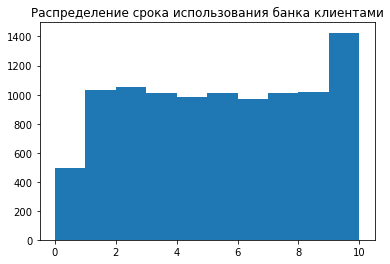

In [12]:
plt.hist(df['tenure'])
plt.title('Распределение срока использования банка клиентами')
plt.show()

### Кодирование номинальных категориальных значений

Закодируем столбцы `gender` и `geopgraphy`. Чтобы не попасть в дамми-ловушку используем параметр `drop_first=True`.

In [13]:
df = pd.get_dummies(df, drop_first=True)

In [14]:
df.head()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,geography_Germany,geography_Spain,gender_Male
RowNumber,,,,,,,,,,,,
1,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
2,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
3,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
4,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
5,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


### Разбиение на выборки

Отделим целевой признак

In [15]:
X = df.drop(['exited'], axis=1)
y = df['exited']

In [16]:
X.head()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_Germany,geography_Spain,gender_Male
RowNumber,,,,,,,,,,,
1,619,42,2.0,0.00,1,1,1,101348.88,0,0,0
2,608,41,1.0,83807.86,1,0,1,112542.58,0,1,0
3,502,42,8.0,159660.80,3,1,0,113931.57,0,0,0
4,699,39,1.0,0.00,2,0,0,93826.63,0,0,0
5,850,43,2.0,125510.82,1,1,1,79084.10,0,1,0


Посмотрим на корреляцию признаков

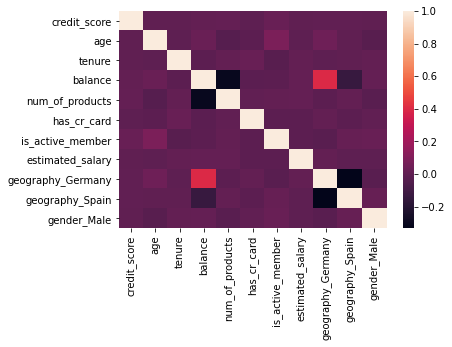

In [17]:
sns.heatmap(X.corr())
plt.show()

Сильной связи между признаками нет. Это будет плюсом в обучении моделей

Разделим наш датасет на обучающую, валидационную и тестовую выборки в соотношении 3:1:1.

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, stratify=y, shuffle=True, random_state=RAND)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, stratify=y_test, shuffle=True, random_state=RAND)

In [19]:
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

(6000, 11)
(2000, 11)
(2000, 11)


### Масштабирование признаков

Признаки имеют разные масштабы значений. Из-за этого веса у линейных моделей будет сильно различаться. Чтобы избежать этого нам нужно стандартизировать численные значения признаков

In [20]:
numeric = ['credit_score', 'age', 'tenure', 'balance', 'num_of_products', 'estimated_salary']

In [21]:
scaler = StandardScaler()
scaler.fit(X_train[numeric])

StandardScaler()

In [22]:
X_train[numeric] = scaler.transform(X_train[numeric])
X_valid[numeric] = scaler.transform(X_valid[numeric])
X_test[numeric] = scaler.transform(X_test[numeric])

In [23]:
X_train.head()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_Germany,geography_Spain,gender_Male
RowNumber,,,,,,,,,,,
9889,-0.146693,-1.697167,1.750023,0.790433,-0.894961,0,0,1.288735,0,0,0
951,-0.167463,0.856837,1.062211,0.872216,0.824465,1,1,-0.998410,0,0,0
7334,0.497161,0.383873,-1.001225,0.963769,0.824465,1,0,-0.311937,0,1,1
9765,-0.520544,0.100095,1.750023,0.354747,0.824465,0,0,-0.395882,0,0,1
1265,1.930254,-0.751240,1.406117,0.452091,-0.894961,0,1,-0.864426,0,1,1


In [24]:
X_valid.head()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_Germany,geography_Spain,gender_Male
RowNumber,,,,,,,,,,,
3421,0.299851,-0.751240,-1.345131,-1.231753,0.824465,1,1,-1.694190,0,0,1
4413,0.154464,0.100095,-1.001225,-1.231753,0.824465,0,0,-1.117762,0,0,0
2020,0.569854,-0.845833,-0.657319,0.351341,-0.894961,1,1,0.168743,0,0,1
6530,1.919870,-0.183683,-0.313413,-1.231753,0.824465,1,0,0.182692,0,1,0
8353,-0.665930,0.951430,0.718305,1.267890,0.824465,1,0,-1.517912,1,0,0


In [25]:
X_test.head()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_Germany,geography_Spain,gender_Male
RowNumber,,,,,,,,,,,
4606,-1.257860,-0.467462,1.062211,-1.231753,0.824465,0,1,0.712708,0,0,0
8261,-0.115539,-0.845833,0.030493,-0.713827,-0.894961,0,1,0.705308,1,0,0
2332,-1.486324,-1.035018,-1.689037,0.315927,0.824465,1,0,0.817522,1,0,1
4530,0.133695,0.478466,1.062211,1.068356,-0.894961,1,1,0.254315,0,0,0
3684,-0.780162,1.235208,1.406117,1.506517,0.824465,0,0,0.827307,0,0,0


Теперь данные готовы для моделирования

### Вывод

Изучили данные: датафрейм состоит из 10 000 строк и 14 столбцов, также было 909 пропусков в столбце `tenure`.

В ходе предобработки данных:
1. Преобразовали столбец `RowNumber` в индекс
2. Удалили столбцы `CustomerId`и `Surname`, так как эти признаки будут мешать при обучении моделей - идентификаторы/фамилии пользователей уникальны и не влияют на факт ухода клиента.
3. Привели названия столбцов к нижнему регистру с разделителем `_`.
4. В данных представлена информация о клиентах из трех стран: 50% из Франции и по 25% из Германии и Испании.
5. Распределение по годам использования банка почти равномерное (столбец `tenure`), поэтому заменили 909 пропусков случайными числами, снизив влияние на наше распределение. При заполнении медианой мы бы увеличили в 2 раза значение для 5 лет, что кажется некорректным.
6. Применили к столбцам `gender` и `geography` прямое кодирование.
7. Разделили данные на обучающую, валидационную и тестовую выборки в соотношении 3:1:1.
8. Стандартизировали количественные признаки для восприятия их алгоритмом однозначными.

# Моделирование

## Исследование баланса классов

Посмотрим соотношение количества значений в столбце `exited`.

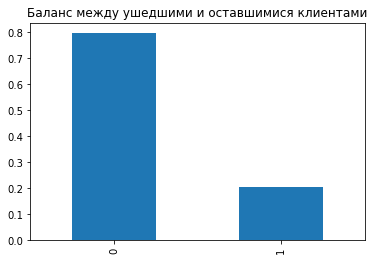

In [26]:
df['exited'].value_counts(normalize=True).plot(kind='bar')
plt.title('Баланс между ушедшими и оставшимися клиентами')
plt.show()

Виден явный дисбаланс классов в пользу отрицательного класса в соотношении 4:1. Если мы будем всех людей прогнозировать, что они не уйдут из банка, то в 80% случаев мы будем правы

## Исследование моделей без учета дисбаланса классов

Найдем лучшую модель дерева решений, случайного леса и логистической регрессии по метрике F1-мера без учета дисбаланса класса.

#### Дерево решений

In [27]:
best_model_dt = None
best_result_dt = 0

for depth in range(1, 31):
    # обучаем модель с заданой глубиной дерева решений
    model_dt = DecisionTreeClassifier(max_depth=depth, random_state=RAND)
    # обучаем модель на обучающей выборке
    model_dt.fit(X_train, y_train)
    # посчитаем качество модели на валидационной выборке
    predicted_valid_dt = model_dt.predict(X_valid)
    result_dt = f1_score(y_valid, predicted_valid_dt)
    
    # посчитаем метрику AUC-ROC
    probabilities_valid_dt = model_dt.predict_proba(X_valid)
    probabilities_one_valid_dt = probabilities_valid_dt[:, 1]
    auc_roc_dt = roc_auc_score(y_valid, probabilities_one_valid_dt)
    
    if result_dt > best_result_dt:
        # сохраняем наилучшую модель и наилучшее значение метрик F1-мера и AUC-ROC
        # на валидационных данных для дерева решений
        best_model_dt = model_dt
        best_result_dt = result_dt
        best_depth = depth
        best_auc_roc_dt = auc_roc_dt
        
print("F1-мера наилучшей модели на валидационной выборке:", best_result_dt)
print("AUC-ROC лучшей модели:", best_auc_roc_dt)
print('max_depth: ', best_depth)

F1-мера наилучшей модели на валидационной выборке: 0.5257142857142858
AUC-ROC лучшей модели: 0.7599610396220565
max_depth:  10


#### Случайный лес

In [28]:
best_model_rf = None
best_result_rf = 0

for est in range(100, 1001, 100):
    for depth in range(1, 22, 2):
        # обучаем модель с заданой глубиной дерева решений и заданным количеством деревьев
        model_rf = RandomForestClassifier(n_estimators=est, max_depth=depth, random_state=RAND)
        # обучаем модель на обучающей выборке
        model_rf.fit(X_train, y_train)
        # посчитаем качество модели на валидационной выборке
        predicted_valid_rf = model_rf.predict(X_valid)
        result_rf = f1_score(y_valid, predicted_valid_rf)
        # посчитаем метрику AUC-ROC
        probabilities_valid_rf = model_rf.predict_proba(X_valid)
        probabilities_one_valid_rf = probabilities_valid_rf[:, 1]
        auc_roc_rf = roc_auc_score(y_valid, probabilities_one_valid_rf)
        
        if result_rf > best_result_rf:
            # сохраняем наилучшую модель и наилучшие значения метрик F1-мера и AUC-ROC
            # на валидационных данных для случайного леса
            best_model_rf = model_rf
            best_result_rf = result_rf
            best_est = est
            best_depth_rf = depth
            best_auc_roc_rf = auc_roc_rf
        
print("F1-мера наилучшей модели на валидационной выборке:", best_result_rf)
print("AUC-ROC лучшей модели:", best_auc_roc_rf)
print('n_estimators: ', best_est)
print('max_depth:', best_depth_rf)

F1-мера наилучшей модели на валидационной выборке: 0.5379746835443038
AUC-ROC лучшей модели: 0.8431952753986653
n_estimators:  100
max_depth: 17


#### Логистическая регрессия

In [29]:
# обучаем модель логистической регрессии с количеством итераций 1000
model_lr = LogisticRegression(solver='liblinear', max_iter=1000, random_state=RAND)
# обучаем модель на обучающей выборке
model_lr.fit(X_train, y_train)
# посчитаем качество модели на валидационной выборке
predicted_valid_lr = model_lr.predict(X_valid)
result_lr = f1_score(y_valid, predicted_valid_lr)
# посчитаем метрику AUC-ROC
probabilities_valid_lr = model_lr.predict_proba(X_valid)
probabilities_one_valid_lr = probabilities_valid_lr[:, 1]
auc_roc_lr = roc_auc_score(y_valid, probabilities_one_valid_lr)


print('F1-мера модели логистической регрессии на валидационной выборке:', result_lr)
f'AUC-ROC лучшей модели: {auc_roc_lr}'

F1-мера модели логистической регрессии на валидационной выборке: 0.3188405797101449


'AUC-ROC лучшей модели: 0.7546930597778054'

#### Вывод

In [30]:
metrics_db = pd.DataFrame({'model':['Дерево решений','Случайный лес','Логистическая регрессия'], 
                         'F1-мера':[best_result_dt,best_result_rf,result_lr],
                         'AUC-ROC':[best_auc_roc_dt,best_auc_roc_rf,auc_roc_lr]
                        })
metrics_db

,model,F1-мера,AUC-ROC
0,Дерево решений,0.525714,0.759961
1,Случайный лес,0.537975,0.843195
2,Логистическая регрессия,0.318841,0.754693


Лучше всего по метрике F1-мера (0.538) себя показала модель случайного леса с количеством деревьев 100 и глубиной 17. Также у нее получился самый высокий AUC-ROC.

## Борьба с дисбалансом

### Взвешивание классов

Найдем наилучшую модель с учетом дисбаланса классов за счет взвешивания классов `class_weight='balanced'`

#### Дерево решений

In [31]:
best_model_dt_w = None
best_result_dt_w = 0

for depth in range(1,31):
    # обучаем модель с заданой глубиной дерева решений
    model_dt_w = DecisionTreeClassifier(max_depth=depth, class_weight='balanced', random_state=RAND)
    # обучаем модель на обучающей выборке
    model_dt_w.fit(X_train, y_train)
    # посчитаем качество модели на валидационной выборке
    predicted_valid_dt_w = model_dt_w.predict(X_valid)
    result_dt_w = f1_score(y_valid, predicted_valid_dt_w)
    
    # посчитаем метрику AUC-ROC
    probabilities_valid_dt_w = model_dt_w.predict_proba(X_valid)
    probabilities_one_valid_dt_w = probabilities_valid_dt_w[:, 1]
    auc_roc_dt_w = roc_auc_score(y_valid, probabilities_one_valid_dt_w)
    
    if result_dt_w > best_result_dt_w:
        # сохраняем наилучшую модель и наилучшее значение метрик F1-мера и AUC-ROC
        # на валидационных данных для дерева решений
        best_model_dt_w = model_dt_w
        best_result_dt_w = result_dt_w
        best_depth_w = depth
        best_auc_roc_dt_w = auc_roc_dt_w
        
print("F1-мера наилучшей модели на валидационной выборке:", best_result_dt_w)
print("AUC-ROC лучшей модели:", best_auc_roc_dt_w)
print('max_depth: ', best_depth_w)

F1-мера наилучшей модели на валидационной выборке: 0.5653206650831354
AUC-ROC лучшей модели: 0.8044554569978298
max_depth:  5


#### Случайный лес

In [32]:
best_model_rf_w = None
best_result_rf_w = 0

for est in range(100, 1001, 100):
    for depth in range(1, 22, 2):
        # обучаем модель с заданой глубиной дерева решений и заданным количеством деревьев
        model_rf_w = RandomForestClassifier(n_estimators=est, max_depth=depth, class_weight='balanced', random_state=RAND)
        # обучаем модель на обучающей выборке
        model_rf_w.fit(X_train, y_train)
        # посчитаем качество модели на валидационной выборке
        predicted_valid_rf_w = model_rf_w.predict(X_valid)
        result_rf_w = f1_score(y_valid, predicted_valid_rf_w)
        # посчитаем метрику AUC-ROC
        probabilities_valid_rf_w = model_rf_w.predict_proba(X_valid)
        probabilities_one_valid_rf_w = probabilities_valid_rf_w[:, 1]
        auc_roc_rf_w = roc_auc_score(y_valid, probabilities_one_valid_rf_w)
        
        if result_rf_w > best_result_rf_w:
            # сохраняем наилучшую модель и наилучшие значения метрик F1-мера и AUC-ROC
            # на валидационных данных для случайного леса
            best_model_rf_w = model_rf_w
            best_result_rf_w = result_rf_w
            best_est_w = est
            best_depth_rf_w = depth
            best_auc_roc_rf_w = auc_roc_rf_w
        
print("F1-мера наилучшей модели на валидационной выборке:", best_result_rf_w)
print("AUC-ROC лучшей модели:", best_auc_roc_rf_w)
print('n_estimators: ', best_est_w)
print('max_depth:', best_depth_rf_w)

F1-мера наилучшей модели на валидационной выборке: 0.6137184115523465
AUC-ROC лучшей модели: 0.856563805716348
n_estimators:  300
max_depth: 9


#### Логистическая регрессия

In [33]:
# обучаем модель логистической регрессии с количеством итераций 1000
model_lr_w = LogisticRegression(solver='liblinear', max_iter=1000, class_weight='balanced', random_state=RAND)
# обучаем модель на обучающей выборке
model_lr_w.fit(X_train, y_train)
# посчитаем качество модели на валидационной выборке
predicted_valid_lr_w = model_lr_w.predict(X_valid)
result_lr_w = f1_score(y_valid, predicted_valid_lr_w)
# посчитаем метрику AUC-ROC
probabilities_valid_lr_w = model_lr_w.predict_proba(X_valid)
probabilities_one_valid_lr_w = probabilities_valid_lr_w[:, 1]
auc_roc_lr_w = roc_auc_score(y_valid, probabilities_one_valid_lr_w)


print('F1-мера модели логистической регрессии на валидационной выборке:', result_lr_w)
f'AUC-ROC лучшей модели: {auc_roc_lr_w}'

F1-мера модели логистической регрессии на валидационной выборке: 0.4888888888888889


'AUC-ROC лучшей модели: 0.757458537119554'

#### Вывод

In [34]:
metrics_w = pd.DataFrame({'model':['Дерево решений','Случайный лес','Логистическая регрессия'], 
                         'F1-мера':[best_result_dt_w,best_result_rf_w,result_lr_w],
                         'AUC-ROC':[best_auc_roc_dt_w,best_auc_roc_rf_w,auc_roc_lr_w]
                        })
metrics_w

,model,F1-мера,AUC-ROC
0,Дерево решений,0.565321,0.804455
1,Случайный лес,0.613718,0.856564
2,Логистическая регрессия,0.488889,0.757459


Лучше всего по метрике F1-мера (0.6137) себя показала модель случайного леса с количеством деревьев 300 и глубиной 9

### Увеличение выборки

Применим технику `upsampling` и увеличим нашу выборку.

Преобразование проходит в несколько этапов:
* Разделим обучающую выборку на отрицательные и положительные объекты;
* Скопируем несколько раз положительные объекты;
* С учётом полученных данных создадим новую обучающую выборку;
* Перемешаем данные: идущие друг за другом одинаковые вопросы не помогут обучению.

In [35]:
# напишем функцию upsample для увеличения выборки
# с тремя переменными: признаки, целевой признак и количество повторений
def upsample(features, target, repeat):
    # разделим выборку на положительные и отрицательные объекты
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    # продублируем объекты положительного класса (* repeat) и объединим их с объектами отрицательного класса
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    # перемешаем наши значения
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=RAND)
    # вернем увеличенную выборку
    return features_upsampled, target_upsampled

In [36]:
# увеличим обучающую выборку (положительные значения в 4 раза)
X_upsampled, y_upsampled = upsample(X_train, y_train, 4)

#### Дерево решений

In [37]:
best_model_dt_us = None
best_result_dt_us = 0

for depth in range(1, 31):
    # обучаем модель с заданой глубиной дерева решений
    model_dt_us = DecisionTreeClassifier(max_depth=depth, random_state=RAND)
    # обучаем модель на обучающей выборке
    model_dt_us.fit(X_upsampled, y_upsampled)
    # посчитаем качество модели на валидационной выборке
    predicted_valid_dt_us = model_dt_us.predict(X_valid)
    result_dt_us = f1_score(y_valid, predicted_valid_dt_us)
    
    # посчитаем метрику AUC-ROC
    probabilities_valid_dt_us = model_dt_us.predict_proba(X_valid)
    probabilities_one_valid_dt_us = probabilities_valid_dt_us[:, 1]
    auc_roc_dt_us = roc_auc_score(y_valid, probabilities_one_valid_dt_us)
    
    if result_dt_us > best_result_dt_us:
        # сохраняем наилучшую модель и наилучшее значение метрик F1-мера и AUC-ROC
        # на валидационных данных для дерева решений
        best_model_dt_us = model_dt_us
        best_result_dt_us = result_dt_us
        best_depth_us = depth
        best_auc_roc_dt_us = auc_roc_dt_us
        
print("F1-мера наилучшей модели на валидационной выборке:", best_result_dt_us)
print("AUC-ROC лучшей модели:", best_auc_roc_dt_us)
print('max_depth: ', best_depth_us)

F1-мера наилучшей модели на валидационной выборке: 0.5653206650831354
AUC-ROC лучшей модели: 0.8044554569978298
max_depth:  5


#### Случайный лес

In [38]:
best_model_rf_us = None
best_result_rf_us = 0

for est in range(100, 1001, 100):
    for depth in range(1, 22, 2):
        # обучаем модель с заданой глубиной дерева решений и заданным количеством деревьев
        model_rf_us = RandomForestClassifier(n_estimators=est, max_depth=depth, random_state=RAND)
        # обучаем модель на обучающей выборке
        model_rf_us.fit(X_upsampled, y_upsampled)
        # посчитаем качество модели на валидационной выборке
        predicted_valid_rf_us = model_rf_us.predict(X_valid)
        result_rf_us = f1_score(y_valid, predicted_valid_rf_us)
        # посчитаем метрику AUC-ROC
        probabilities_valid_rf_us = model_rf_us.predict_proba(X_valid)
        probabilities_one_valid_rf_us = probabilities_valid_rf_us[:, 1]
        auc_roc_rf_us = roc_auc_score(y_valid, probabilities_one_valid_rf_us)
        
        if result_rf_us > best_result_rf_us:
            # сохраняем наилучшую модель и наилучшие значения метрик F1-мера и AUC-ROC
            # на валидационных данных для случайного леса
            best_model_rf_us = model_rf_us
            best_result_rf_us = result_rf_us
            best_est_us = est
            best_depth_rf_us = depth
            best_auc_roc_rf_us = auc_roc_rf_us
        
print("F1-мера наилучшей модели на валидационной выборке:", best_result_rf_us)
print("AUC-ROC лучшей модели:", best_auc_roc_rf_us)
print('n_estimators: ', best_est_us)
print('max_depth:', best_depth_rf_us)

F1-мера наилучшей модели на валидационной выборке: 0.6212290502793296
AUC-ROC лучшей модели: 0.8534111923942431
n_estimators:  100
max_depth: 9


#### Логистическая регрессия

In [39]:
# обучаем модель логистической регрессии с количеством итераций 1000
model_lr_us = LogisticRegression(solver='liblinear', max_iter=1000, random_state=RAND)
# обучаем модель на обучающей выборке
model_lr_us.fit(X_upsampled, y_upsampled)
# посчитаем качество модели на валидационной выборке
predicted_valid_lr_us = model_lr_us.predict(X_valid)
result_lr_us = f1_score(y_valid, predicted_valid_lr_us)
# посчитаем метрику AUC-ROC
probabilities_valid_lr_us = model_lr_us.predict_proba(X_valid)
probabilities_one_valid_lr_us = probabilities_valid_lr_us[:, 1]
auc_roc_lr_us = roc_auc_score(y_valid, probabilities_one_valid_lr_us)


print('F1-мера модели логистической регрессии на валидационной выборке:', result_lr_us)
f'AUC-ROC лучшей модели: {auc_roc_lr_us}'

F1-мера модели логистической регрессии на валидационной выборке: 0.49452554744525545


'AUC-ROC лучшей модели: 0.7574662489916727'

#### Вывод

In [40]:
metrics_us = pd.DataFrame({'model':['Дерево решений','Случайный лес','Логистическая регрессия'], 
                         'F1-мера':[best_result_dt_us,best_result_rf_us,result_lr_us],
                         'AUC-ROC':[best_auc_roc_dt_us,best_auc_roc_rf_us,auc_roc_lr_us]
                        })
metrics_us

,model,F1-мера,AUC-ROC
0,Дерево решений,0.565321,0.804455
1,Случайный лес,0.621229,0.853411
2,Логистическая регрессия,0.494526,0.757466


Лучше всего по метрике F1-мера (0.6212) себя показала модель случайного леса с количеством деревьев 100 и глубиной 9

### Вывод по моделированию

In [41]:
metrics = pd.DataFrame({'model':['Дерево решений','Случайный лес','Логистическая регрессия'], 
                        'F1-мера db':[best_result_dt,best_result_rf,result_lr],
                         'AUC-ROC db':[best_auc_roc_dt,best_auc_roc_rf,auc_roc_lr],
                        'F1-мера w':[best_result_dt_w,best_result_rf_w,result_lr_w],
                         'AUC-ROC w':[best_auc_roc_dt_w,best_auc_roc_rf_w,auc_roc_lr_w],
                         'F1-мера us':[best_result_dt_us,best_result_rf_us,result_lr_us],
                         'AUC-ROC us':[best_auc_roc_dt_us,best_auc_roc_rf_us,auc_roc_lr_us]
                        })
metrics

,model,F1-мера db,AUC-ROC db,F1-мера w,AUC-ROC w,F1-мера us,AUC-ROC us
0,Дерево решений,0.525714,0.759961,0.565321,0.804455,0.565321,0.804455
1,Случайный лес,0.537975,0.843195,0.613718,0.856564,0.621229,0.853411
2,Логистическая регрессия,0.318841,0.754693,0.488889,0.757459,0.494526,0.757466


Мы рассмотрели 3 варианта обучения моделей. Во всех случаях наилучший результат показала модель случайного леса.

Без учета дисбаланса классов значение `F1-меры = 0.538` (100 деревьев с глубиной 17). Значение `AUC-ROC = 0.84`.

*Мы улучшили качество модели, учитывая дисбаланс классов, двумя способами:*

**1) Взвешивание классов.**

Лучший результат показала модель случайного леса (300 дерево с глубиной 9) с `F1-мера = 0.6137`, `AUC-ROC = 0.8565`.

**2) Увеличение обучающей выборки**

Лучший результат показала модель случайного леса (100 деревьев с глубиной 9) с `F1-мера = 0.6212`, `AUC-ROC = 0.8534`.

<div style="border:solid blue 2px; padding: 20px">
    Лучшая модель - случайный лес с количеством деревьев 100, глубиной 9 при учете дисбаланса классов за счет увеличения выборки.
</div>

## Тестирование модели

In [42]:
# обучаем модель с заданой глубиной дерева решений и заданным количеством деревьев
model = RandomForestClassifier(n_estimators=100, max_depth=9, random_state=RAND)
# обучаем модель на обучающей выборке
model.fit(X_upsampled, y_upsampled)
# посчитаем качество модели на тестовой выборке
predicted_test = model.predict(X_test)
result = f1_score(y_test, predicted_test)

print("F1-мера модели на тестовой выборке:", result)

F1-мера модели на тестовой выборке: 0.6127292340884575


In [43]:
# посчитаем метрику AUC-ROC
probabilities_test = model.predict_proba(X_test)
probabilities_one_test = probabilities_test[:, 1]
auc_roc = roc_auc_score(y_test, probabilities_one_test)
print("AUC-ROC лучшей модели:", auc_roc)

AUC-ROC лучшей модели: 0.8597983791506553


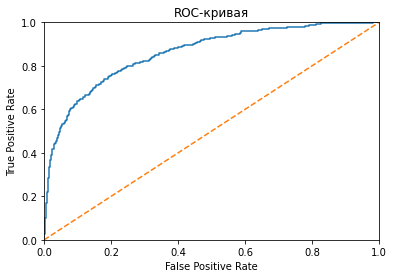

In [44]:
fpr, tpr, thresholds = roc_curve(y_test, probabilities_one_test)

plt.figure()
plt.plot(fpr,tpr)
plt.title('ROC-кривая')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.show()

Чем выше график, тем больше значение TPR и лучше качество модели.

**Результат выбранной модели на тестовой выборке `F1-мера = 0.61` и `AUC-ROC = 0.86`.**

## Вывод

Целью данного проекта было создание модели по прогнозированию ухода клиента из банка в ближайшее время.

Наилучшей моделью стала *модель случайного леса* с гиперпараметрами `max_depth = 9` и `n_estimators = 100` при учёте дисбаланса классов за счет увеличения выборки. При финальном тестировании она показала высокое значение метрик: `F1-мера = 0.61` (по поставленной задаче должна быть не менее 0.59) и `AUC-ROC = 0.86`.

В ходе определения модели с лучшими гиперпараметрами было выполнено сравнение зависимости метрики F1-мера от дисбаланса классов (во всех случаях обучения наилучший результат показывала модель случайного леса).

Без учета дисбаланса классов значение `F1-меры = 0.538` (100 деревьев с глубиной 17). Значение `AUC-ROC = 0.84`.

*Мы улучшили качество модели, учитывая дисбаланс классов, двумя способами:*

**1) Взвешивание классов.**

Лучший результат показала модель случайного леса (300 дерево с глубиной 9) с `F1-мера = 0.6137`, `AUC-ROC = 0.8565`.

**2) Увеличение обучающей выборки**

Лучший результат показала модель случайного леса (100 деревьев с глубиной 9) с `F1-мера = 0.6212`, `AUC-ROC = 0.8534`.

Также была сделана подготовка данных к обучению.

1. Удалены столбцы `CustomerId`и `Surname`.
2. Названия столбцов приведены  к нижнему регистру с разделителем `_`.
3. Применили к столбцам `gender` и `geography` прямое кодирование.
4. Заменили пропуски в столбце `tenure` случайными числами. Распределение по годам использования банка равномерное, поэтому мы исключили влияние на это распределение. При заполнении медианой мы бы увеличили в 2 раза значение для 5 лет, что кажется некорректным.
5. Разделили данные на обучающую, валидационную и тестовую выборки в соотношении 3:1:1.
6. Стандартизировали количественные признаки для восприятия их алгоритмом однозначными.